In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

with zipfile.ZipFile("/content/drive/MyDrive/signalarbeit.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/signalarbeit")

In [ ]:
import numpy as np
from numpy.fft import fft, ifft

def iaaft_surrogate(x, n_iter=100):
    """
    IAAFT yÃ¶ntemiyle surrogate veri Ã¼retiyoruz burda

    x: orijinal zaman serisi
    n_iter: iterasyon sayÄ±sÄ± (tipik olarak 100 civarÄ± yeterlidir)
    """
    # 1. Orijinal verinin genlik sÄ±ralamasÄ±
    sorted_x = np.sort(x)

    # 2. Orijinalin genlik spektrumu
    orig_fft = fft(x)
    amplitude = np.abs(orig_fft)

    # 3. Rastgele baÅŸlangÄ±Ã§
    np.random.seed(0)
    y = np.random.permutation(x)

    for i in range(n_iter):
        # Fourier dÃ¶nÃ¼ÅŸtÃ¼r
        s_fft = fft(y)

        # Orijinalin amplitÃ¼dÃ¼nÃ¼ kullan, yeni fazÄ± koru
        s_fft = amplitude * np.exp(1j * np.angle(s_fft))

        # Ters Fourier
        y = np.real(ifft(s_fft))

        # AmplitÃ¼dÃ¼ sÄ±rala (orijinalle aynÄ± histogram)
        ranks = np.argsort(np.argsort(y))
        y = sorted_x[ranks]

    return y


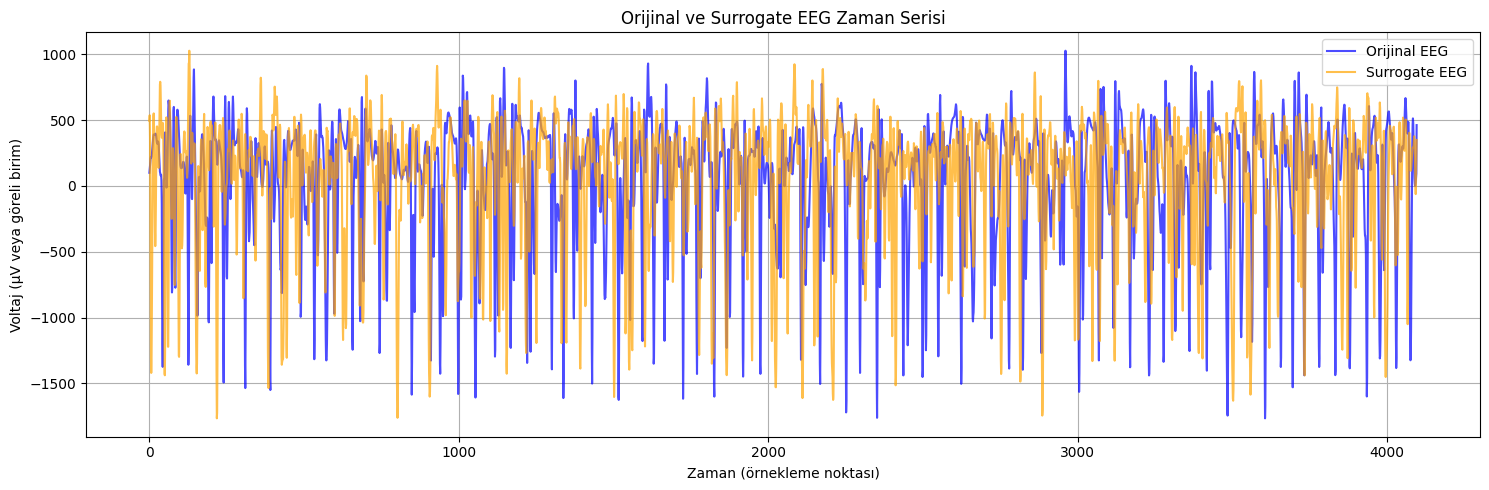

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Veri dosyasÄ±nÄ± oku
filepath = r"/content/signalarbeit/s/S001.txt"
data = np.loadtxt(filepath)#[:1000]

# Surrogate veriyi oluÅŸtur
surrogate = iaaft_surrogate(data)

# GrafiÄŸi Ã§iz
plt.figure(figsize=(15, 5))
plt.plot(data, label="Orijinal EEG", color='blue', alpha=0.7)
plt.plot(surrogate, label="Surrogate EEG", color='orange', alpha=0.7)
plt.title("Orijinal ve Surrogate EEG Zaman Serisi")
plt.xlabel("Zaman (Ã¶rnekleme noktasÄ±)")
plt.ylabel("Voltaj (ÂµV veya gÃ¶reli birim)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


burada da p deÄŸeri bakÄ±yorum

In [ ]:
def nonlinear_prediction_error(x, m=6, tau=8, H=65, k=5):
    """
    Nonlinear Prediction Error (P) hesaplar.

    x: zaman serisi
    m: gÃ¶mme boyutu (embedding dimension)
    tau: zaman gecikmesi
    H: tahmin ufku (kaÃ§ adÄ±m ileri)
    k: en yakÄ±n komÅŸu sayÄ±sÄ±
    """
    import numpy as np
    from scipy.spatial import KDTree

    N = len(x) - (m - 1) * tau - H
    if N <= 0:
        raise ValueError("Zaman serisi Ã§ok kÄ±sa veya H/m/tau Ã§ok bÃ¼yÃ¼k.")

    # Delay embedding
    embedded = np.array([
        x[i : i + m * tau : tau]
        for i in range(N)
    ])

    targets = x[(m - 1) * tau + H : (m - 1) * tau + H + N]

    # KD-tree ile en yakÄ±n k komÅŸuyu bul
    tree = KDTree(embedded)
    pred = []

    for i in range(N):
        dists, idxs = tree.query(embedded[i], k=k+1)  # kendisi de Ã§Ä±kar
        valid_idxs = [j for j in idxs if j != i][:k]
        future_vals = x[(valid_idxs + np.array((m - 1) * tau + H)).tolist()]
        pred.append(np.mean(future_vals))

    pred = np.array(pred)

    # Tahmin hatasÄ±: normalize edilmiÅŸ RMS hata
    rmse = np.sqrt(np.mean((pred - targets)**2))
    baseline_rmse = np.sqrt(np.mean((targets - np.mean(x))**2))

    P = rmse / baseline_rmse
    return P


In [ ]:
# Orijinal veri
P_orig = nonlinear_prediction_error(data)

# Surrogate veri
P_surr = nonlinear_prediction_error(surrogate)

print(f"Orijinal P:  {P_orig:.4f}")
print(f"Surrogate P: {P_surr:.4f}")

if P_orig > P_surr:
    print("Orijinal veri iÃ§in doÄŸrusal olmayan hata oranÄ± 'surrogate' hata oranÄ±ndan daha yÃ¼ksek, tahmin edilebilirliÄŸi daha zor," \
    "Ã§ok da belirli bir dÃ¼zen iÃ§erdiÄŸi kesin olarak sÃ¶ylenemez.")
else:
    print("'Surrogate' veri iÃ§in doÄŸrusal olmayan hata oranÄ± Orijinal hata oranÄ±ndan daha yÃ¼ksek, tahmin edilebilirliÄŸi daha yÃ¼ksek," \
    "orijinal sinyalin 'surrogate' veriye gÃ¶re daha belirli bir dÃ¼zen iÃ§eriyor olma ihtimali var.")

Orijinal P:  0.9723
Surrogate P: 0.9375
Orijinal veri iÃ§in doÄŸrusal olmayan hata oranÄ± 'surrogate' hata oranÄ±ndan daha yÃ¼ksek, tahmin edilebilirliÄŸi daha zor,Ã§ok da belirli bir dÃ¼zen iÃ§erdiÄŸi kesin olarak sÃ¶ylenemez.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Orijinal veri yÃ¼kle
filepath = r"/content/signalarbeit/s/S001.txt"
data = np.loadtxt(filepath)

# 2. Orijinal P hesapla
P_orig = nonlinear_prediction_error(data)

# 3. Surrogate Ã¼ret ve P hesapla
n_surrogates = 20
P_surr_list = []

for i in range(n_surrogates):
    surr = iaaft_surrogate(data)
    P_surr = nonlinear_prediction_error(surr)
    P_surr_list.append(P_surr)

P_surr_array = np.array(P_surr_list)

# 4. P-deÄŸeri hesapla (tek yÃ¶nlÃ¼ test: P_orig < P_surr)
p_value = np.sum(P_surr_array <= P_orig) / n_surrogates
p_value = p_value * 20

# 5. SonuÃ§larÄ± yazdÄ±r
print(f"Orijinal P: {P_orig:.4f}")
print(f"Surrogate P ortalamasÄ±: {np.mean(P_surr_array):.4f}")
print(f"P-deÄŸeri (anlamlÄ±lÄ±k olan): {p_value:.4f}")

if p_value > 0.5:
    print("Orijinal veri iÃ§in doÄŸrusal olmayan hata oranÄ± 20 adet oluÅŸturulmuÅŸ ve 'surrogate' hata oranÄ±ndan daha yÃ¼ksek, tahmin edilebilirliÄŸi daha zor, \n"
    f"Ã§ok da belirli bir dÃ¼zen iÃ§erdiÄŸi kesin olarak sÃ¶ylenemez. surrogate > orijinal sayÄ±sÄ±: {p_value:.4f}")
else:
    print(" Surrogate veri iÃ§in doÄŸrusal olmayan hata oranÄ± Orijinal hata oranÄ±ndan daha yÃ¼ksek, tahmin edilebilirliÄŸi daha yÃ¼ksek," + "\n" +
    f"orijinal sinyalin 'surrogate' veriye gÃ¶re daha belirli bir dÃ¼zen iÃ§eriyor olma ihtimali var. surrogate > orijinal sayÄ±sÄ±: {p_value:.4f}")


Orijinal P: 0.9723
Surrogate P ortalamasÄ±: 0.9375
P-deÄŸeri (anlamlÄ±lÄ±k olan): 20.0000
Orijinal veri iÃ§in doÄŸrusal olmayan hata oranÄ± 20 adet oluÅŸturulmuÅŸ ve 'surrogate' hata oranÄ±ndan daha yÃ¼ksek, tahmin edilebilirliÄŸi daha zor, 
Ã§ok da belirli bir dÃ¼zen iÃ§erdiÄŸi kesin olarak sÃ¶ylenemez. surrogate > orijinal sayÄ±sÄ±: 20.0000


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

data_folder = r"/content/signalarbeit/s"  # Hedef klasÃ¶r (S, N, F, Z, O)
n_surrogates = 20

results = []

for filename in os.listdir(data_folder):
    if filename.endswith(".txt"):
        filepath = os.path.join(data_folder, filename)
        try:
            data = np.loadtxt(filepath)
        except Exception as e:
            print(f"{filename} okunamadÄ±: {e}")
            continue

        print(f"\n--- {filename} ---")

        try:
            P_orig = nonlinear_prediction_error(data)
        except Exception as e:
            print(f"Orijinal sinyal iÃ§in P hatasÄ±: {e}")
            continue

        P_surr_list = []
        for _ in range(n_surrogates):
            surr = iaaft_surrogate(data)
            try:
                P_surr = nonlinear_prediction_error(surr)
                P_surr_list.append(P_surr)
            except:
                continue

        P_surr_array = np.array(P_surr_list)
        p_value = np.sum(P_surr_array <= P_orig) / len(P_surr_array)

        print(f"Orijinal P: {P_orig:.4f} | Surrogate Ort: {np.mean(P_surr_array):.4f} | p-deÄŸeri: {p_value:.4f}")

        results.append({
            "dosya": filename,
            "P_orig": P_orig,
            "P_surr_mean": np.mean(P_surr_array),
            "p_value": p_value
        })



df_results = pd.DataFrame(results)
print("\nTÃ¼m SonuÃ§lar:")
print(df_results)

# CSV olarak dÄ±ÅŸa aktarmak istersen:
# df_results.to_csv("p_results.csv", index=False)



--- S031.txt ---
Orijinal P: 0.7410 | Surrogate Ort: 0.9233 | p-deÄŸeri: 0.0000

--- S044.txt ---
Orijinal P: 0.7910 | Surrogate Ort: 0.7717 | p-deÄŸeri: 1.0000

--- S020.txt ---
Orijinal P: 0.8233 | Surrogate Ort: 0.8949 | p-deÄŸeri: 0.0000

--- S077.txt ---
Orijinal P: 0.7983 | Surrogate Ort: 0.7865 | p-deÄŸeri: 1.0000

--- S008.txt ---
Orijinal P: 0.6373 | Surrogate Ort: 0.8463 | p-deÄŸeri: 0.0000

--- S099.txt ---
Orijinal P: 0.9459 | Surrogate Ort: 0.9667 | p-deÄŸeri: 0.0000

--- S003.txt ---
Orijinal P: 0.9804 | Surrogate Ort: 1.0100 | p-deÄŸeri: 0.0000

--- S036.txt ---
Orijinal P: 0.7953 | Surrogate Ort: 0.7383 | p-deÄŸeri: 1.0000

--- S010.txt ---
Orijinal P: 1.0638 | Surrogate Ort: 1.0335 | p-deÄŸeri: 1.0000

--- S074.txt ---
Orijinal P: 0.7733 | Surrogate Ort: 0.8715 | p-deÄŸeri: 0.0000

--- S023.txt ---
Orijinal P: 0.8245 | Surrogate Ort: 0.9045 | p-deÄŸeri: 0.0000

--- S032.txt ---
Orijinal P: 0.8231 | Surrogate Ort: 0.7453 | p-deÄŸeri: 1.0000

--- S075.txt ---
Orijinal P

KeyboardInterrupt: 

bu kÄ±sÄ±mda da artÄ±k linear prediction error methodunu tÃ¼m sÄ±nÄ±flarda test ediyorum.


ðŸ“Š Grup BazlÄ± Ã–zet:
      P_orij_mean  P_surr_mean  p_mean  n_dosya
grup                                           
f        0.608691     0.632491    0.29      100
s        0.833954     0.858003    0.39      100
z        0.883657     0.890137    0.39      100
o        0.930540     0.937965    0.35      100


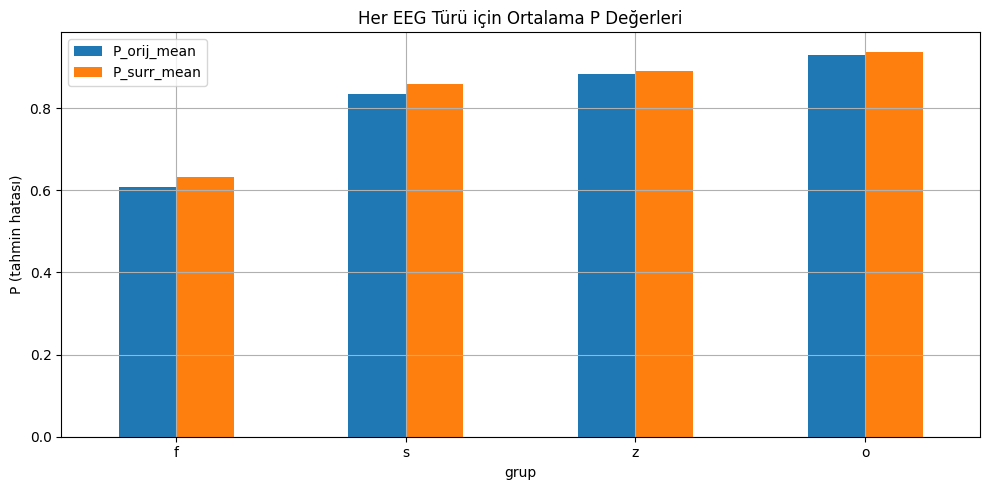

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ana klasÃ¶r yolu
base_dir = r"/content/signalarbeit"
group_labels = ['s', 'f', 'z', 'o']
n_surrogates = 20

# TÃ¼m sonuÃ§lar burada toplanacak
all_results = []

for label in group_labels:
    group_path = os.path.join(base_dir, label)
    for filename in os.listdir(group_path):
        if filename.endswith(".txt"):
            filepath = os.path.join(group_path, filename)
            try:
                data = np.loadtxt(filepath)
                P_orig = nonlinear_prediction_error(data)
            except Exception as e:
                print(f"[{label}/{filename}] bir ssÄ±kÄ±ntÄ± Ã§Ä±ktÄ±: {e}")
                continue

            P_surr_list = []
            for _ in range(n_surrogates):
                try:
                    surr = iaaft_surrogate(data)
                    P_surr = nonlinear_prediction_error(surr)
                    P_surr_list.append(P_surr)
                except:
                    continue

            if len(P_surr_list) == 0:
                continue  # BoÅŸsa geÃ§

            P_surr_array = np.array(P_surr_list)
            p_val = np.sum(P_surr_array <= P_orig) / len(P_surr_array)

            all_results.append({
                "grup": label,
                "dosya": filename,
                "P_orijinal": P_orig,
                "P_surrogate_mean": np.mean(P_surr_array),
                "p_value": p_val
            })

# TÃ¼m sonuÃ§larÄ± pandas ile DataFrame'e dÃ¶k
df = pd.DataFrame(all_results)

# Her grup iÃ§in Ã¶zet istatistikleri hesapla
group_stats = df.groupby("grup").agg({
    "P_orijinal": "mean",
    "P_surrogate_mean": "mean",
    "p_value": ["mean", "count"]
})
group_stats.columns = ['P_orij_mean', 'P_surr_mean', 'p_mean', 'n_dosya']
group_stats = group_stats.sort_values("P_orij_mean")

print("\nðŸ“Š Grup BazlÄ± Ã–zet:")
print(group_stats)

# Ä°stersen grafik de Ã§izebilirsin
group_stats[['P_orij_mean', 'P_surr_mean']].plot(kind='bar', figsize=(10, 5))
plt.title("Her EEG TÃ¼rÃ¼ iÃ§in Ortalama P DeÄŸerleri")
plt.ylabel("P (tahmin hatasÄ±)")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# S - N: saÄŸlÄ±klÄ± kiÅŸiler - gÃ¶zler aÃ§Ä±k ve kapalÄ±
# F - Z - O: hasta kiÅŸiler- nÃ¶bet bÃ¶lgesi ama nÃ¶bet yok - nÃ¶bet olmayan bÃ¶lge nÃ¶bet yok - nÃ¶bet olan bÃ¶lge nÃ¶bet var
# !!!!! bence bir grup daha olmalÄ±ydÄ± onda da nÃ¶bet olmayan bÃ¶lge nÃ¶bet zamanÄ± olmalÄ±ydÄ±